# Lab 2

<b>Class:</b> MSDS 7331 Data Mining
<br> <b>Dataset:</b> Belk Endowment Educational Attainment Data 

<h1 style="font-size:150%;"> Teammates </h1>
Maryam Shahini
<br> Murtada Shubbar
<br> Michael Toolin
<br> Steven Millett

In [2]:
#Set global variables
#Variables for file and school informaiton

YEARS = ['2014', '2015', '2016', '2017']

#Number of features we will be selecting for feature selection

N_FEATURES_OPTIONS = [25,50,100,"all"]

#Alpha and C we will be using for our classifiers

C_ESTIMATORS = [50, 100, 200, 500]
C_DEPTH = [2, 3, 5]
LEARNING_RATE = [1e-2, 1e-1, 1e0]

#Used for KNN gridsearch
C_NEIGHBORS = [4, 5]

#Used for SVC grid search
C_OPTIONS = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]

#Import data all necessary libraries we will be using in our estimation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import sklearn
import statistics
import random


from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile, RFE

from sklearn.preprocessing import StandardScaler, Binarizer

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, auc, roc_curve
from IPython.display import display, HTML

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit, StratifiedShuffleSplit

from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor,AdaBoostClassifier,RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

%%html
<style>
table {float:left}
</style>

# 1.a Data Preparation
10 points - Deﬁne and prepare your class variables. Use proper variable 
representations (int, ﬂoat, one-hot, etc.). Use pre-processing methods (as needed) for
dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for 
the analysis.

# The Belk Endowment Educational Attainment Data Repository for North Carolina Public Schools
Our data set originates from the North Carolina Public Schools Reports and Statistics. This public site contains large amounts of information covering many aspects of the performance of students and schools across the state of North Carolina. It includes public and charter schools ranging from the elementary level to high schools. http://www.ncpublicschools.org/

The data used in our lab consists of portions of this data which includes the school years 2014-2017. The data used is the result of combining and cleaning the raw data sets available on the North Carolina website. The machine learning data sets are broken down by school year and then sub-setted by elementary school, middle school and high school information. 

In this lab our data set consists of all the data available for school years 2015-2017 from the Machine Learning data available.  First step is to combine all the data from previous years and add the variable ‘Year’ to each row, keeping track of which year this data was collected.

Next the each feature is inspected for NA values.  If more than 75% of the feature contains NA, we replace that field with 0.  If less than 75% is NA, then the median value of the column is used to replace the NA.

###Need description of what was done in Altyrex.

Two binary classifications are performed.  The first is classifiying if a schools average SAT score will be above 1000.  This information is useful to teachers and guidance counselors as they are helping students navigate college searches.  The second classifier examines crime rate as compared to the LEA each school is in.



|<p align="">Variable|<p align="">Type|<p align="">Note|
|--------|----|----|
|<p align="">Year|<p align="">Object|<p align="">Tracks year data is from|
|<p align="">local_crime_greater|<p align="">int64|<p align="">1 if crime in school is above LEA average crime, 0 otherwise
|<p align="">X_crime_reduced|<p align="">Data Frame|<p align="">Used in crime reduced scope model, removes racial information from data|
|<p align="">SAT_Score_Above1000|<p align="">int64|<p align="">1 if SAT score is above 1000 ,0 otherwise.

# 1.b Data Preparation
5 points - Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

In [3]:
# The 2017 Public Schools Machine Learning 
# Date Set is being used throughout this 
# analysis.  The _ML suffix is removed to less 
# name space size
# Load Full Public School Data Frames for each year

school_data = pd.DataFrame()

for year in YEARS:
    #Load public school master file
    temp_year = pd.read_csv('../Data/'+str(year)+'/Machine Learning Datasets/PublicHighSchools'+str(year)+'_ML.csv', low_memory=False)
        
    #Add year column and concatonating all data together
    temp_year['Year']=year
    
    if(school_data.empty):
        school_data = pd.concat([school_data,temp_year],ignore_index=True)
    else:
        school_data = pd.concat([school_data,temp_year], join = "inner",ignore_index=True)

print(school_data.shape)

(1904, 288)


In [4]:
#This is the critical threshold
CRITICAL_NA = .75

#With this we check if the column is less than 75% non-NA, if it is greater than 75% non-NA
#We replace the NA with the median of the column, otherwise we replace the value with 0

imputed_school_data = school_data.apply(lambda col: col.fillna(0) if col.count()/col.shape[0]<CRITICAL_NA else col.fillna(col.median()),axis=0)

print(school_data.shape)
school_data.describe()


#This is the master data set! 

(1904, 288)


,student_num,lea_avg_student_num,st_avg_student_num,Biology_Size,English II_Size,Math I_Size,lea_total_expense_num,lea_salary_expense_pct,lea_services_expense_pct,lea_supplies_expense_pct,...,grade_range_cd_PK-12,"calendar_type_txt_Regular School, Year-Round Calendar",esea_status_P,Grad_project_status_Y,SPG Grade_B,SPG Grade_C,SPG Grade_D,EVAAS Growth Status_Met,EVAAS Growth Status_NotMet,unit_code
count,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,...,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000
mean,849.853466,830.111870,828.354517,18.629727,19.313550,18.243172,9093.345021,0.670409,0.081126,0.081555,...,0.006828,0.019433,0.034664,0.398109,0.340336,0.398109,0.087185,0.333508,0.309349,510742.404937
std,588.307262,357.643945,105.106371,5.607309,5.510312,5.544849,1204.493613,0.095046,0.016536,0.015932,...,0.082369,0.138077,0.182975,0.489637,0.473947,0.489637,0.282180,0.471590,0.462347,279912.990415
min,8.000000,105.000000,252.000000,0.000000,0.000000,0.000000,7282.190000,0.547000,0.047000,0.028000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10303.000000
25%,326.500000,584.500000,837.000000,16.000000,17.000000,16.000000,8362.900000,0.611000,0.069000,0.071000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,280330.000000
50%,783.500000,810.000000,848.000000,19.000000,20.000000,19.000000,8820.080000,0.626000,0.080500,0.081000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,490380.000000
75%,1221.250000,974.000000,853.000000,23.000000,23.000000,22.000000,9405.800000,0.655000,0.089000,0.091000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,761304.000000
max,2966.000000,1852.000000,860.000000,32.000000,35.000000,37.000000,17801.850000,0.878000,0.153000,0.143000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,995330.000000


In [5]:
# SAT: adding variables: 

SAT_school_data = school_data.copy()

SAT_school_data['SAT_Score_Above1000'] = SAT_school_data.apply(lambda each_row: 1 if (each_row['sat_avg_score_num']) > 999 else 0,axis=1)
SAT_school_data['SAT_participation_number'] = SAT_school_data.apply(lambda each_row: (each_row['sat_participation_pct'])*(each_row['student_num']) ,axis=1)
SAT_school_data['Student_Num_College_Ready_SAT'] = SAT_school_data.apply(lambda each_row: (each_row['SAT_participation_number']) if (each_row['SAT_Score_Above1000'] == 1) else 0,axis=1)

SAT_school_data.describe()




,student_num,lea_avg_student_num,st_avg_student_num,Biology_Size,English II_Size,Math I_Size,lea_total_expense_num,lea_salary_expense_pct,lea_services_expense_pct,lea_supplies_expense_pct,...,Grad_project_status_Y,SPG Grade_B,SPG Grade_C,SPG Grade_D,EVAAS Growth Status_Met,EVAAS Growth Status_NotMet,unit_code,SAT_Score_Above1000,SAT_participation_number,Student_Num_College_Ready_SAT
count,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,...,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000
mean,849.853466,830.111870,828.354517,18.629727,19.313550,18.243172,9093.345021,0.670409,0.081126,0.081555,...,0.398109,0.340336,0.398109,0.087185,0.333508,0.309349,510742.404937,0.435399,411.521127,225.294859
std,588.307262,357.643945,105.106371,5.607309,5.510312,5.544849,1204.493613,0.095046,0.016536,0.015932,...,0.489637,0.473947,0.489637,0.282180,0.471590,0.462347,279912.990415,0.495939,379.676251,405.623422
min,8.000000,105.000000,252.000000,0.000000,0.000000,0.000000,7282.190000,0.547000,0.047000,0.028000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10303.000000,0.000000,0.000000,0.000000
25%,326.500000,584.500000,837.000000,16.000000,17.000000,16.000000,8362.900000,0.611000,0.069000,0.071000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,280330.000000,0.000000,133.605000,0.000000
50%,783.500000,810.000000,848.000000,19.000000,20.000000,19.000000,8820.080000,0.626000,0.080500,0.081000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,490380.000000,0.000000,314.703500,0.000000
75%,1221.250000,974.000000,853.000000,23.000000,23.000000,22.000000,9405.800000,0.655000,0.089000,0.091000,...,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,761304.000000,1.000000,565.942500,285.960000
max,2966.000000,1852.000000,860.000000,32.000000,35.000000,37.000000,17801.850000,0.878000,0.153000,0.143000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,995330.000000,1.000000,2358.030000,2358.030000


In [6]:

#replace this section with the above data set. SAT_school_data
#------------------------------------------------------------------------------------------


#reading in new dataset wrangled using Alteryx. 
#SAT_Filtered = pd.DataFrame()
#SAT_Filtered = pd.read_csv('../Data/School Datasets/HighSchoolCleanFinal.csv', low_memory=False)

#SAT_Filtered.describe()


#SAT_Score_above1000	 Boolean: SAT score above 1000 or not to get into a decent college in NC. 
#SAT_participation_number	 Estimate of number of students that took the SAT
#Student_Num_College_Ready_SAT	 Estimate of the number of students that can apply to college without SAT score hinderance from that school. 


# Get list of highly correlated features

In [7]:
# corr_matrix = imputed_school_data.corr().abs()

# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# # Find index of feature columns with correlation greater than 0.95
# to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]

# print(to_drop)

# 2.a Modeling and Evaluation
Using the right evaluation metric for classification system is crucial. Otherwise, it may results in thinking that the model is performing well but in reality, it doesn’t.

There are two tasks in this section of “NC Educational Data” project:

The first task is to predict a binary classification target, either if the average SAT score of each school is good enough to gets the student to the North Carolina Universities or not. The SAT is a standardized test widely used for college admissions in the United States. For this purpose we have a cut off 1200 out of 1600. The second task is to predict if the crime per 100 students at each school level is higher than the LEA level or not. After considering all evaluation metrics for classification systems, we ended up using ROC Curve. Area under ROC Curve (or AUC for short) is a performance metric for binary classification problems.

In fact, a ROC curve can be used to select a threshold for a classifier which maximizes the true positives, while minimizing the false positives.

We usually use ROC when both classes detection are important. Here, our models should be able to decrease both false positive rate (which is identifying the schools with enough good average SAT score for getting admission in different universities) and also decreasing the false negative rate (which is detecting schools with not good average SAT scores).

The same for the second task, it is important to decrease both false positive and false negative rates.

The AUC represents a model’s ability to discriminate between positive and negative classes. An area of 1.0 represents a model that made all predictions perfectly. An area of 0.5 represents a model as good as random. Most classifiers have AUCs that fall somewhere between these two values. Therefore, the overall model performances can be compared by considering the AUC.

# 2.b Modeling and Evaluation
10 points - Choose the method you will use for dividing your data into training and why testing splits (i.e., are you using Stratiﬁed 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate.

Two different data frames based on the same data are used for SAT classification and crime classification. Each data frame is initially split into a training and a test data set. We set aside 20% of the complete data set to test against.  During the training of the model, a standard 10 fold cross validation technique, which. We chose to shuffle the data during the cross validation to provide a higher confidence there was no grouping of schools that we did not notice.

Other options available are the Stratifeid k-fold technique which works to balance the ratio of labels used in each fold.  Our dependent variable (local_crime_greater) has approximately a 45-55% split (see pie chart below), and with a large enough data set we can have a high level of confidence of a random split in the data without using Stratfied techniques.  The same held true for the SAT score where the split was approximately 56%-44% (see pie chart below) 

We chose a K fold (10 folds) validation algorithm, however a  Shuffle Split may have performed just as well with this size data set. Where Shuffle Split is capable of creating n folds and fitting the data using n-1 to train and 1 to test against, there is a chance the same data will appear in the test set each time the data is sampled. We chos K fold to insure each value is used in the training set.


We chose not use the Leave One Out (LOO) cross validation due to the computational cost on data set as complex as this.  Empirical evidence has shown a 10-fold cross validation is preferred to the LOO algorithm

Grouping algorithms were not relevant to our data set as we do not have groups of dependent variables.

(soure:http://scikit-learn.org/stable/modules/cross_validation.html)


# Task 1: Crime - Classification Model

In [8]:
# split X and y into test and train sets. We still want
# to do this for external Cross Validation

crime_imputed_school_data = imputed_school_data

crime_imputed_school_data['local_crime_greater'] = crime_imputed_school_data.apply(lambda each_row: 1 if (each_row['crime_per_c_num']-each_row['lea_crime_per_c_num'])<0 else 0,axis=1)

#split data into X and y dataframes

y_crime = crime_imputed_school_data['local_crime_greater']

#Removed SPG Grade and unit code(which is primary key for school data table)
 
X_crime = imputed_school_data[school_data.columns.drop(list(school_data.filter(regex='crime|lea|LEA|^st\_')))]

X_crime_train, X_crime_test, y_crime_train, y_crime_test = train_test_split(X_crime, y_crime, test_size=.2)
y_crime.dtype

dtype('int64')

54.41% of the schools have local crime higher then their local LEA average in the training set


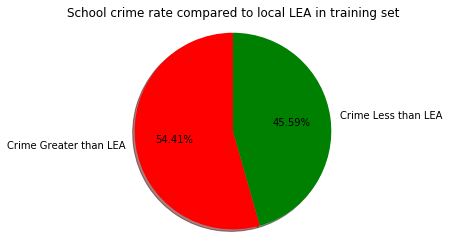

In [9]:
print ('{0:.2%} of the schools have local crime higher then their local LEA average in the training set'.format(y_crime.sum()/len(y_crime)))
labels = 'Crime Greater than LEA', 'Crime Less than LEA',
scores = [(y_crime.sum()/len(y_crime)), 1-(y_crime.sum()/len(y_crime))]
colors = ['red','green']
 
# Plot
plt.pie(scores, labels=labels, colors=colors,
        autopct='%1.2f%%', shadow=True, startangle=90)
 
plt.axis('equal')
plt.title('School crime rate compared to local LEA in training set')
plt.show()

# Task 2: SAT Score - Classification Model

In [10]:
# To split X and y into test and train sets.

y_SAT = SAT_school_data['SAT_Score_Above1000']

#Removed SAT_SCore_above1000 and unit code(which is primary key for school data table)
 
X_SAT = SAT_school_data[SAT_school_data.columns.drop(list(SAT_school_data.filter(regex='SAT_Score|SAT_score|SAT_SCORE|sat_avg|unit_code|lea|LEA|^st\_')))]



43.54% of the schools have SAT scores above 1000 in the training set


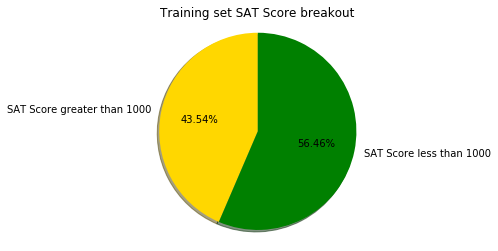

In [11]:
X_SAT_train, X_SAT_test, y_SAT_train, y_SAT_test = train_test_split(X_SAT, y_SAT, test_size=.2)
print ('{0:.2%} of the schools have SAT scores above 1000 in the training set'.format(y_SAT.sum()/len(y_SAT)))
y_SAT.dtype
labels = 'SAT Score greater than 1000', 'SAT Score less than 1000',
scores = [(y_SAT.sum()/len(y_SAT)), 1-(y_SAT.sum()/len(y_SAT))]
colors = ['gold','green']
 
# Plot
plt.pie(scores, labels=labels, colors=colors,
        autopct='%1.2f%%', shadow=True, startangle=90)
plt.title('Training set SAT Score breakout')
 
plt.axis('equal')
plt.show()

In [12]:
#y_SAT.head()
#X_SAT.shape
#SAT_Filtered.shape
#X_SAT.SAT_Score_above1000

# 2.c Modeling and Evaluation
20 points - Create three different classification/regression models (e.g., random forest, KNN, and SVM). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric.

In [13]:
k_fold = KFold(n_splits=10,shuffle=True)

#This creates the template for the pipeline
# This creates a basic pipeline where we will 
# test for dementionality reduction, scaling,
# and classification.


pipe = Pipeline([ ('reduce_dim',SelectKBest(chi2)),
                  ('scale', StandardScaler()), 
                  ('clf', GradientBoostingClassifier())])

# SAT Model #1 : Random Forest Classifier

In [14]:
param_grid = [
    {
         'reduce_dim__k': N_FEATURES_OPTIONS,
         'clf': [RandomForestClassifier()],
         'clf__n_estimators': C_ESTIMATORS, 
         'clf__max_depth': C_DEPTH,
     }
]

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=k_fold,n_jobs=-1, verbose=1 )

SAT_RandomForest_model = grid_search.fit(X_SAT_train, y_SAT_train)

y_SAT_score1 = grid_search.predict(X_SAT_test)
y_SAT_prob1=grid_search.predict_proba(X_SAT_test)

print(roc_auc_score(y_SAT_test, y_SAT_prob1[:,1]))

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  1.1min finished


1.0


In [ ]:
# Plot ROC Curve



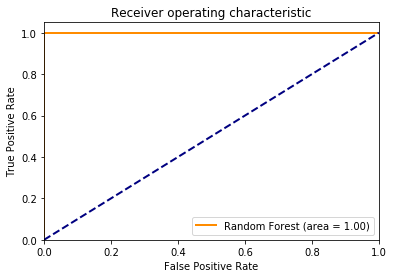

In [15]:
# create ROC cuve for Random Forest model:
fpr1, tpr1, _ = roc_curve(y_SAT_test, y_SAT_prob1[:,1] )
roc_auc1 = auc(fpr1, tpr1)
lw=2
plt.figure()
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='Random Forest (area = %0.2f)' % roc_auc1)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# SAT Model #2 : KNN Classifier

In [16]:
############################
param_grid = [
    {
         'reduce_dim__k': N_FEATURES_OPTIONS,
         'clf': [KNeighborsClassifier()],
         'clf__n_neighbors': C_NEIGHBORS, 
     }
]

grid_search = GridSearchCV(pipe, param_grid=param_grid,cv=k_fold,n_jobs=-1, verbose=1 )

SAT_KNearest_model = grid_search.fit(X_SAT_train, y_SAT_train)

y_SAT_score2 = grid_search.predict(X_SAT_test)

y_SAT_prob2=grid_search.predict_proba(X_SAT_test)

print(roc_auc_score(y_SAT_test, y_SAT_prob2[:,1]))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   13.2s finished


0.9432374541003671


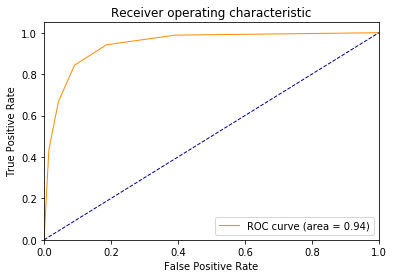

In [17]:
# Plot ROC Curve
from sklearn.metrics import roc_curve, auc
fpr2, tpr2, _ = roc_curve(y_SAT_test, y_SAT_prob2[:,1] )
roc_auc2 = auc(fpr2, tpr2)
lw=1

plt.figure()
plt.plot(fpr2, tpr2, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


# SAT Model #3 :  SVC Classifier

In [20]:
##########################
param_grid = [
    {
         'reduce_dim__k': N_FEATURES_OPTIONS,
         'clf': [SVC(probability=True)],
         'clf__C': C_OPTIONS, 
     }
]

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=k_fold,n_jobs=-1, verbose=1 )

SAT_SVC_model = grid_search.fit(X_SAT_train, y_SAT_train)

y_SAT_score3 = grid_search.predict(X_SAT_test)
y_SAT_prob3=grid_search.predict_proba(X_SAT_test)

print(roc_auc_score(y_SAT_test, y_SAT_prob3[:,1]))

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.6min finished


0.9944920440636474


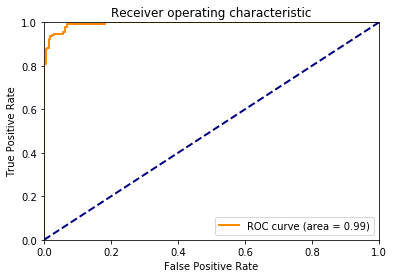

In [21]:
# Plot ROC Curve
from sklearn.metrics import roc_curve, auc
fpr3, tpr3, _ = roc_curve(y_SAT_test, y_SAT_prob3[:,1] )
roc_auc3 = auc(fpr3, tpr3)
lw=2

plt.figure()
plt.plot(fpr3, tpr3, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc3)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Crime Models

# Crime Model #1: Gradient Boosting

In [22]:
 param_grid = [
    {
         'reduce_dim__k': N_FEATURES_OPTIONS,
         'clf':[GradientBoostingClassifier()],
         'clf__n_estimators': C_ESTIMATORS, 
         'clf__max_depth': C_DEPTH,
         'clf__learning_rate':LEARNING_RATE
     }
]


# # This will test the parameter dict against our 
# # pipeline

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=k_fold,n_jobs=-1, verbose=1 )


# # Here we are training the model, this is 
# # what takes the most amount of time to run
crime_GradientBoost_model = grid_search.fit(X_crime_train, y_crime_train)


y_crime_GradientBoost_score = grid_search.predict(X_crime_test)
y_crime_GradientBoost_prob = grid_search.predict_proba(X_crime_test)
print(roc_auc_score(y_crime_test, y_crime_GradientBoost_prob[:,1]))


Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  8.4min finished


0.7558575978161964


In [ ]:
# Plot ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_crime_test, y_crime_GradientBoost_prob[:,1])
roc_auc = auc(fpr, tpr)
lw=1

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Crime dataROC curve using Gradient boosting')
plt.legend(loc="lower right")
plt.show()

In [125]:
pipe.set_params(**crime_GradientBoost_model.best_params_)
pipe.fit(X_crime_train, y_crime_train)


Pipeline(memory=None,
     steps=[('reduce_dim', SelectKBest(k='all', score_func=<function chi2 at 0x000002D45324B1E0>)), ('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=2,
...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

In [126]:
coef = pipe.steps[2][1].feature_importances_

mask = pipe.steps[0][1].get_support()
new_features=[]
feature_names=list(X_crime_train.columns.values)
for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)

#Creates a new dataframe with the coefficients and the 
predicted_data = pd.DataFrame(data=coef,index=new_features,columns=['Influence'])
print("The top 10 features that influence SPG Grade are the following")



display(predicted_data.sort_values(by='Influence', ascending=False)[0:10])

The top 10 features that influence SPG Grade are the following


,Influence
avg_daily_attend_pct,0.413839
GraduationRate_5yr_All,0.095217
EOCSubjects_CACR_EDS,0.080979
short_susp_per_c_num,0.075098
SPG Score,0.061636
GraduationRate_4yr_Male,0.054384
long_susp_per_c_num,0.044745
EOCMathI_CACR_Black,0.029972
EOCEnglish2_CACR_Female,0.025893
ACTCompositeScore_UNCMin_Black,0.013007


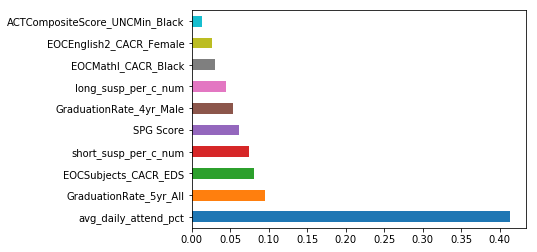

In [127]:
feat_importances = pd.Series(pipe.steps[2][1].feature_importances_, index=X_crime_train.columns)
feat_importances = feat_importances.nlargest(10)
feat_importances.plot(kind='barh')

# Crime Model #2: Ada Boost

In [47]:
 param_grid = [
    {
         'reduce_dim__k': N_FEATURES_OPTIONS,
         'clf': [AdaBoostClassifier()],
         'clf__n_estimators': C_ESTIMATORS,
         'clf__learning_rate':LEARNING_RATE
     }
]


# # This will test the parameter dict against our 
# # pipeline

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=k_fold,n_jobs=-1, verbose=1 )


# # Here we are training the model, this is 
# # what takes the most amount of time to run
crime_ADABoost_model = grid_search.fit(X_crime_train, y_crime_train)

y_crime_ADABoost_score = grid_search.predict(X_crime_test)

print(roc_auc_score(y_crime_test, y_crime_ADABoost_score))


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  5.8min finished


0.6623153935505282


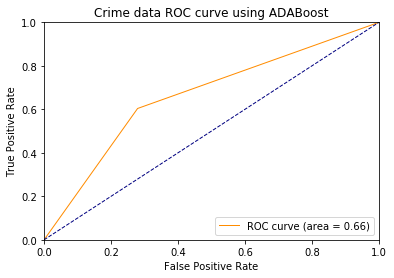

In [48]:
# Plot ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_crime_test, y_crime_ADABoost_score )
roc_auc = auc(fpr, tpr)
lw=1

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Crime data ROC curve using ADABoost')
plt.legend(loc="lower right")
plt.show()

In [88]:
print(crime_ADABoost_model.best_params_)

{'clf': AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=50, random_state=None), 'clf__learning_rate': 0.1, 'clf__n_estimators': 50, 'reduce_dim__k': 'all'}


# Crime Model #3: Random Forest Classifier

In [27]:
 param_grid = [
    {
         'reduce_dim__k': N_FEATURES_OPTIONS,
         'clf': [RandomForestClassifier()],
         'clf__n_estimators': C_ESTIMATORS, 
         'clf__max_depth': C_DEPTH,
     }
]


# # This will test the parameter dict against our 
# # pipeline

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=k_fold,n_jobs=-1, verbose=1 )


# # Here we are training the model, this is 
# # what takes the most amount of time to run
crime_RandomForest_model = grid_search.fit(X_crime_train, y_crime_train)

y_crime_RandomForest_score = grid_search.predict(X_crime_test)

print(roc_auc_score(y_crime_test, y_crime_RandomForest_score))

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  2.0min finished


0.6508241606283532


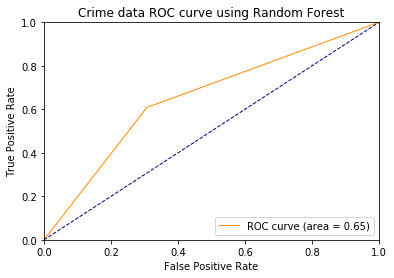

In [49]:
# Plot ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_crime_test, y_crime_RandomForest_score )
roc_auc = auc(fpr, tpr)
lw=1

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Crime data ROC curve using Random Forest')
plt.legend(loc="lower right")
plt.show()

In [28]:
print(crime_RandomForest_model.best_params_)
print(crime_RandomForest_model.multimetric_)

{'clf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), 'clf__max_depth': 5, 'clf__n_estimators': 200, 'reduce_dim__k': 'all'}
False


# Crime Model #4: KNN

In [51]:

param_grid = [
    {
         'reduce_dim__k': N_FEATURES_OPTIONS,
         'clf': [KNeighborsClassifier()],
         'clf__n_neighbors': C_NEIGHBORS, 
     }
]


# # This will test the parameter dict against our 
# # pipeline

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=k_fold,n_jobs=-1, verbose=1 )


# # Here we are training the model, this is 
# # what takes the most amount of time to run
crime_KNearest_model = grid_search.fit(X_crime_train, y_crime_train)

y_crime_KNearest_score = grid_search.predict(X_crime_test)

print(roc_auc_score(y_crime_test, y_crime_score))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.2s


0.5912107970573595


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   20.4s finished


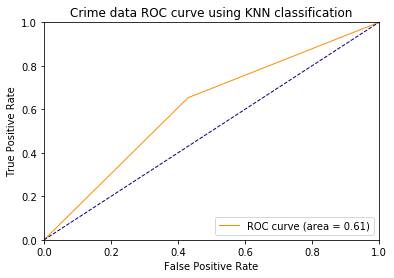

In [52]:
# Plot ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_crime_test, y_crime_KNearest_score )
roc_auc = auc(fpr, tpr)
lw=1

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Crime data ROC curve using KNN classification')
plt.legend(loc="lower right")
plt.show()

In [53]:
print(crime_KNearest_model.best_params_)

{'clf': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'), 'clf__n_neighbors': 5, 'reduce_dim__k': 25}


# Crime Model #5: Bagging Method

In [31]:
param_grid = [
    {
         'reduce_dim__k': N_FEATURES_OPTIONS,
         'clf': [BaggingClassifier(DecisionTreeClassifier())],
         'clf__n_estimators': C_ESTIMATORS 
     }
]


# # This will test the parameter dict against our 
# # pipeline

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=k_fold,n_jobs=-1, verbose=1 )


# # Here we are training the model, this is 
# # what takes the most amount of time to run
crime_Bagging_model = grid_search.fit(X_crime_train, y_crime_train)

y_crime_Bagging_score = grid_search.predict(X_crime_test)

print(roc_auc_score(y_crime_test, y_crime_Bagging_score))

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 12.2min finished


0.6200979036451132


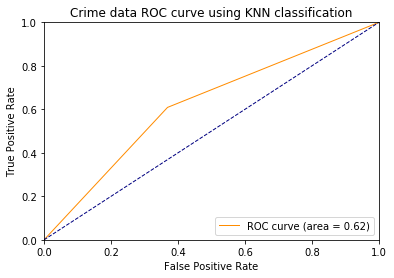

In [54]:
# Plot ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_crime_test, y_crime_Bagging_score )
roc_auc = auc(fpr, tpr)
lw=1

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Crime data ROC curve using KNN classification')
plt.legend(loc="lower right")
plt.show()

In [128]:
pipe.set_params(**crime_Bagging_model.best_params_)
pipe.fit(X_crime_train, y_crime_train)


Pipeline(memory=None,
     steps=[('reduce_dim', SelectKBest(k=50, score_func=<function chi2 at 0x000002D45324B1E0>)), ('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_featur...stimators=500, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False))])

In [129]:
clf = pipe.steps[2][1]

coef = np.mean([
    tree.feature_importances_ for tree in clf.estimators_
], axis=0)

mask = pipe.steps[0][1].get_support()
new_features=[]
feature_names=list(X_crime_train.columns.values)
for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)

#Creates a new dataframe with the coefficients and the 
predicted_data = pd.DataFrame(data=coef,index=new_features,columns=['Influence'])
print("The top 10 features that influence SPG Grade are the following")



display(predicted_data.sort_values(by='Influence', ascending=False)[0:10])

The top 10 features that influence SPG Grade are the following


,Influence
short_susp_per_c_num,0.106244
EOCSubjects_CACR_EDS,0.057279
unit_code,0.034537
EOCEnglish2_CACR_Male,0.031523
student_num,0.029926
EOCEnglish2_CACR_EDS,0.026123
EOCSubjects_CACR_Black,0.025231
EOCMathI_CACR_Black,0.025217
GraduationRate_4yr_SWD,0.024027
EOCMathI_CACR_White,0.023666


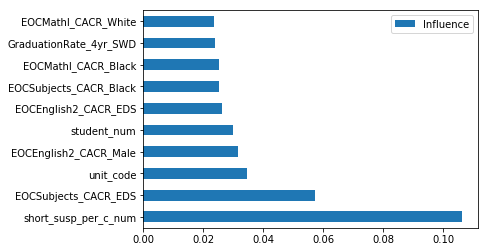

In [131]:
predicted_data.sort_values(by='Influence', ascending=False)[0:10].plot(kind='barh')

## Crime ROC Model comparison
When we plot all ROC curves on the same chart we can see some evidence that all models are providing the same type of results.  The ADA Boost Classifier appears to have a slightly better rate of True Positive vs False Positive classification

<Figure size 432x288 with 0 Axes>

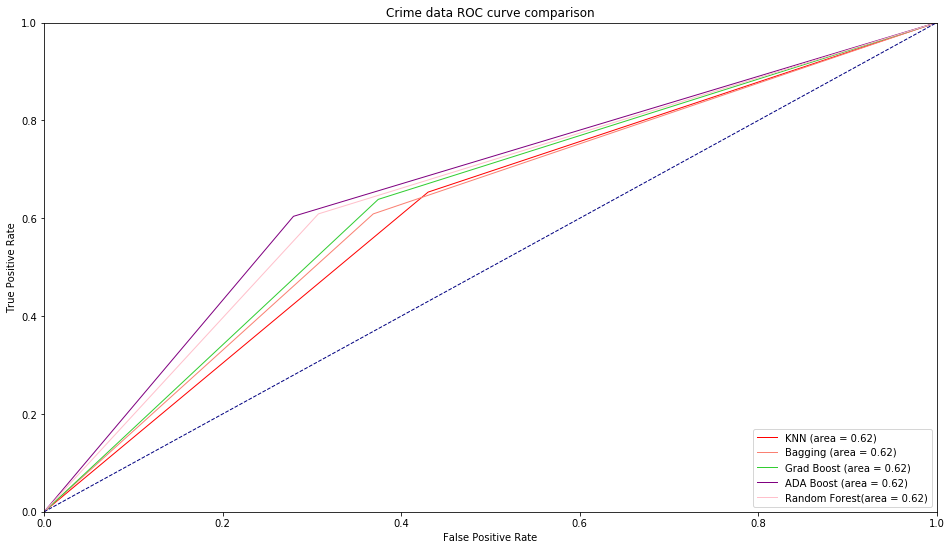

In [74]:
# Plot ROC Curve
from sklearn.metrics import roc_curve, auc
fpr1, tpr1, _ = roc_curve(y_crime_test, y_crime_KNearest_score )
fpr2, tpr2, _ = roc_curve(y_crime_test, y_crime_Bagging_score )
fpr3, tpr3, _ = roc_curve(y_crime_test, y_crime_GradientBoost_score)
fpr4, tpr4, _ = roc_curve(y_crime_test, y_crime_ADABoost_score)
fpr5, tpr5, _ = roc_curve(y_crime_test, y_crime_RandomForest_score)
roc_auc = auc(fpr, tpr)
lw=1

plt.figure()
plt.figure(figsize=(16,9))
plt.plot(fpr1, tpr1, color='red', lw=1, label='KNN (area = %0.2f)' % roc_auc)
plt.plot(fpr2, tpr2, color='salmon', lw=1, label='Bagging (area = %0.2f)' % roc_auc)
plt.plot(fpr3, tpr3, color='limegreen', lw=1, label='Grad Boost (area = %0.2f)' % roc_auc)
plt.plot(fpr4, tpr4, color='purple', lw=1, label='ADA Boost (area = %0.2f)' % roc_auc)
plt.plot(fpr5, tpr5, color='pink', lw=1, label='Random Forest(area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Crime data ROC curve comparison')
plt.legend(loc="lower right")

plt.show()

<Figure size 432x288 with 0 Axes>

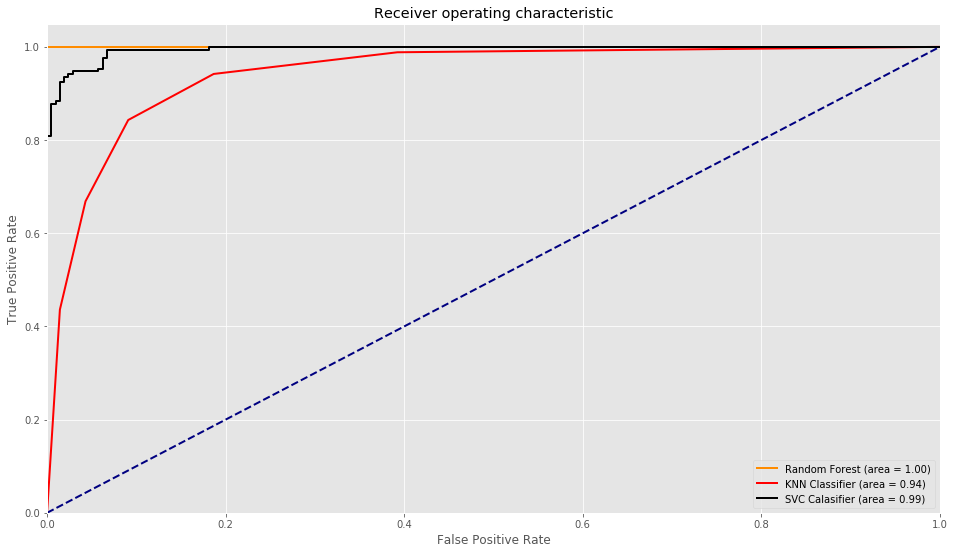

In [28]:
#SAT Models Comparison with ROC curves for all 3 models:
fpr1, tpr1, _ = roc_curve(y_SAT_test, y_SAT_prob1[:,1] )
roc_auc1 = auc(fpr1, tpr1)
fpr2, tpr2, _ = roc_curve(y_SAT_test, y_SAT_prob2[:,1] )
roc_auc2 = auc(fpr2, tpr2)
fpr3, tpr3, _ = roc_curve(y_SAT_test, y_SAT_prob3[:,1] )
roc_auc3 = auc(fpr3, tpr3)
lw=2
plt.figure()
plt.figure(figsize=(16,9))
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='Random Forest (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='red', lw=2, label='KNN Classifier (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, color='black', lw=2, label='SVC Calasifier (area = %0.2f)' % roc_auc3)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Reduced scope model

In [133]:
X_crime_reduced = X_crime[X_crime.columns.drop(list(X_crime.filter(regex='[Ww]hite|[Mm]ale|[Pp]acific[Ii]sland|[Aa]sian|[Hh]ispanic|[Rr]ace|[Bb]lack|[Mm]inority|[Tw]wo[Oo]r[Mm]ore|[Ii]ndian|[Ww]hite')))]
X_crime_reduced_train, X_crime_reduced_test, y_crime_reduced_train, y_crime_reduced_test = train_test_split(X_crime_reduced, y_crime, test_size=.2)

In [134]:
# print(X_crime_reduced.shape)

In [135]:
#  param_grid = [
#     {
#          'reduce_dim__k': N_FEATURES_OPTIONS,
#          'clf__n_estimators': C_ESTIMATORS, 
#          'clf__max_depth': C_DEPTH,
#      }
# ]


# # # This will test the parameter dict against our 
# # # pipeline

# grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=k_fold,n_jobs=-1, verbose=1 )


# # # Here we are training the model, this is 
# # # what takes the most amount of time to run
# crime_reduced_GradientBoost_model = grid_search.fit(X_crime_reduced_train, y_crime_reduced_train)


# y_crime_reduced_score = grid_search.predict(X_crime_reduced_test)

# print(roc_auc_score(y_crime_reduced_test, y_crime_reduced_score))


Based on the contributing features to the model we wanted to remove possible politically biased items that could create unfavorable models with regard to making policies to improve crime outcomes for the high schools in the schools specified in these North Carolina models. We wanted to remove any indicators that could possibly indicate the race of and makeup of the student body so as to not disadvantage any group of students with any recommendations for policy changes.

# Reduced method using Gradient Boost method

In [136]:
pipe.set_params(**crime_GradientBoost_model.best_params_)
pipe.fit(X_crime_reduced_train, y_crime_reduced_train)

y_crime_reduced_score = pipe.predict(X_crime_reduced_test)

print(roc_auc_score(y_crime_reduced_test, y_crime_reduced_score))

0.6542603125517699


In [139]:
coef = pipe.steps[2][1].feature_importances_

mask = pipe.steps[0][1].get_support()
new_features=[]
feature_names=list(X_crime_reduced_train.columns.values)
for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)

#Creates a new dataframe with the coefficients and the 
predicted_data = pd.DataFrame(data=coef,index=new_features,columns=['Influence'])
print("The top 10 features that influence SPG Grade are the following")



display(predicted_data.sort_values(by='Influence', ascending=False)[0:10])

The top 10 features that influence SPG Grade are the following


,Influence
avg_daily_attend_pct,0.295370
SPG Score,0.188907
GraduationRate_5yr_All,0.165514
EOCSubjects_CACR_EDS,0.122017
ACTMath_ACTBenchmark_All,0.048207
English II Score,0.037984
cte_courses,0.023930
advance_dgr_pct,0.022714
short_susp_per_c_num,0.022523
grade_range_cd_PK-12,0.014346


# Reduced method using Bagging method

In [187]:
pipe.set_params(**crime_Bagging_model.best_params_)
pipe.fit(X_crime_reduced_train, y_crime_reduced_train)

y_crime_bagging_reduced_score = pipe.predict(X_crime_reduced_test)

print(roc_auc_score(y_crime_reduced_test, y_crime_bagging_reduced_score))

0.6751033912324235


In [188]:
clf = pipe.steps[2][1]

coef = np.mean([
    tree.feature_importances_ for tree in clf.estimators_
], axis=0)

mask = pipe.steps[0][1].get_support()
new_features=[]
feature_names=list(X_crime_reduced_train.columns.values)
for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)

#Creates a new dataframe with the coefficients and the 
predicted_data = pd.DataFrame(data=coef,index=new_features,columns=['Influence'])
print("The top 10 features that influence SPG Grade are the following")



display(predicted_data.sort_values(by='Influence', ascending=False)[0:10])

The top 10 features that influence SPG Grade are the following


,Influence
avg_daily_attend_pct,0.113200
SPG Score,0.038475
short_susp_per_c_num,0.027886
stud_internet_comp_num,0.021834
English II Score,0.018600
tchyrs_0thru3_pct,0.014998
ACTMath_ACTBenchmark_All,0.014125
_1yr_tchr_trnovr_pct,0.013998
unit_code,0.013895
advance_dgr_pct,0.013620


# 2.d Modeling and Evaluation
10 points - Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.

# 2.e Modeling and Evaluation
10 points - Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference signiﬁcant with 95% conﬁdence? Use proper statistical comparison methods.

# Feature Importance for the Top Performing Model
10 points - Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classiﬁcation task.

As wa mentioned in model evaluation part, the top performing models are Bagging for crime task and Random Forest for SAT task.

The features that have the biggest impact on the model performance for each of these two models are evaluated. 

* All features are scaled in the model.
* The coeficient values indicate the level of feature influence on model performance, higher value means stronger influence and importance.
* The influence values are sorted and top 30 features with strongest influences are plotted.


# Feature Evaluation for the top performing SAT Model: Random Forest Classifier

In [25]:
pipe.set_params(**SAT_RandomForest_model.best_params_)
pipe.fit(X_SAT_train, y_SAT_train)

coef = pipe.steps[2][1].feature_importances_

mask = pipe.steps[0][1].get_support()
new_features=[]
feature_names=list(X_SAT_train.columns.values)
for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)

#Creates a new dataframe with the coefficients and the 
predicted_data = pd.DataFrame(data=coef,index=new_features,columns=['Influence'])
print("The top 20 features that influence SAT Score are the following")
display(predicted_data.sort_values(by='Influence', ascending=False)[0:20])

The top 20 features that influence SAT Score are the following


,Influence
Student_Num_College_Ready_SAT,0.505236
ACTMath_ACTBenchmark_All,0.101398
ACTScience_ACTBenchmark_All,0.098419
EOCMathI_CACR_White,0.043250
ACTMath_ACTBenchmark_Male,0.041557
ACTScience_ACTBenchmark_Male,0.038207
ACTEnglish_ACTBenchmark_Female,0.037296
ACTWriting_ACTBenchmark_All,0.029220
SAT_participation_number,0.019159
ACTWriting_ACTBenchmark_Male,0.018482


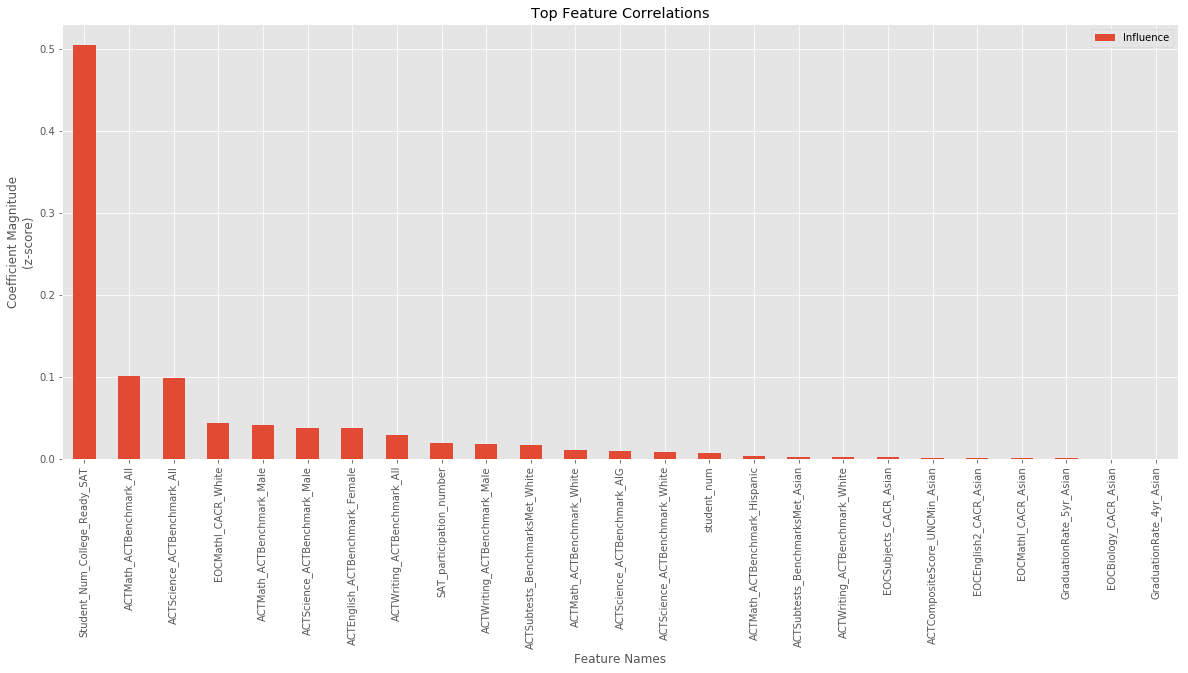

In [27]:
plt.style.use('ggplot')
Importances=predicted_data.sort_values(by='Influence', ascending=False)[0:30]
wt_plt_df = predicted_data.head(75)

weights = pd.Series(wt_plt_df['Influence'].values,index=wt_plt_df.index)
ax = Importances.plot(kind='bar', figsize=(20,8))




ax.set_title("Top Feature Correlations")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

# Deployment
5 points - How useful is yolur model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?

# Exceptional Work
10 points - You have free reign to provide additional modeling. 
One idea: grid search parameters in a parallelized fashion and visualize the 
performances across attributes. Which parameters are most signiﬁcant for making a 
good model for each classiﬁcation algorithm?